# Maximum Likelihood Estimation of the Student t distribution using EM Algorithm

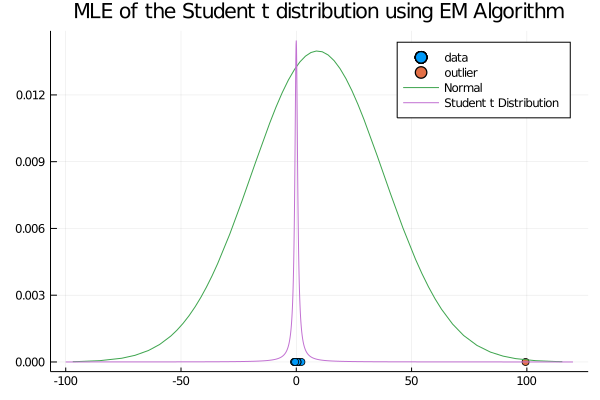

In [1]:
using Plots
using StatsPlots
using Random
using Distributions
using SpecialFunctions
using Statistics
using StatsBase
using Optim
using ReverseDiff: gradient

Random.seed!(1234)

function e_eta(x, nu, lambda_, mu)
    return (nu + 1)/(nu + lambda_ * (x - mu)^2)
end

function e_etas(X, nu, lambda_, mu)
    return [ e_eta(x, nu, lambda_, mu) for x in X]
end

function e_log_eta(x, nu, lambda_, mu)
    return digamma((nu + 1.0)/2.0) - log((nu + lambda_ * (x - mu)^2)/2.0)
end

function e_log_etas(X, nu, lambda_, mu)
    return [ e_log_eta(x, nu, lambda_, mu) for x in X]
end

function fit_t(X)
    n = length(X)
    
    # init
    mu = median(X)
    lambda_ = iqr(X)/2.0
    nu = 1.0
   
    for i in 1:1000
        # E step
        e_etas_ = e_etas(X, nu, lambda_, mu)
        e_log_etas_ = e_log_etas(X, nu[1], lambda_, mu)
        
        
        # M step
        # mu
        mu = (X' * e_etas_) / sum(e_etas_)
        # lambda_
        lambda_ = 1.0 / ( (((X .- mu).^2)' * e_etas_) / n)
        # nu
        function f(nu)
            return digamma(nu[1]/2.0) - log(nu[1]/2.0) - (1.0 + sum(e_log_etas_)/n - sum(e_etas_)/n)
        end
        for j in 1:1000
            tmp = nu - f([nu])/gradient(f, [nu])[1]
            if !isnan(tmp)
                nu = max(tmp, 1e-6)
                if abs(f([nu])) < 1e-6
                    break
                end
            else
                break
            end
        end
    end
    
    return mu, lambda_, nu
end

d = Normal(0.0, 1.0)
noise_d = Normal(100.0, 1.0)
data = rand(d, 10)
outlier = rand(noise_d, 1)
X = vcat(data, outlier)
mu, lambda_, nu = fit_t(X)

# scatter(X, zeros(length(X)), label="")
scatter(data, zeros(length(data)), label="data")
scatter!(outlier, zeros(length(outlier)), label="outlier")
plot!(fit_mle(Normal, X), label="Normal")

Xs = Array(range(-100, 120, step=0.1))
function t_pdf(x, mu, lamda_, nu)
    return gamma((nu+1)/2)./gamma(nu/2).*sqrt(lambda_/(pi*nu)).*(1 .+ lambda_*(x .- mu).^2/nu).^(-(nu+1)/2)
end
Ys = t_pdf(Xs, mu, lambda_, nu)
plot!(Xs, Ys.*0.035, label="Student t Distribution", title="MLE of the Student t distribution using EM Algorithm")